In [1]:
import numpy as np
import os
import tensorflow as tf

from matplotlib import pyplot as plt
from PIL import Image

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

/home/ubuntu/bob/models/research/object_detection/utils/visualization_utils.py:25: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ubuntu/anaconda3/envs/t

In [2]:
PATH_TO_CKPT = '/home/ubuntu/bob/models/research/object_detection/logs_whale_resnet101_export/frozen_inference_graph.pb'
PATH_TO_LABELS = "/home/ubuntu/bob/TensorBob/examples/whale/od/label_map.pbtxt"
from_path = '/home/ubuntu/data/kaggle/humpback/test'
to_path = '/home/ubuntu/data/kaggle/humpback/test_crop'
# PATH_TO_CKPT = '/home/tensorflow05/zyy/models/research/object_detection/logs_whale_resnet50_export/frozen_inference_graph.pb'
# PATH_TO_LABELS = "/home/tensorflow05/zyy/tensorbob/examples/whale/od/label_map.pbtxt"
# from_path = '/home/tensorflow05/data/kaggle/humpback_whale_identification/train'
# to_path = '/home/tensorflow05/data/kaggle/humpback_whale_identification/train_crop'
IMAGE_SIZE = (12, 8)
NUM_CLASSES = 1
BATCH_SIZE = 32
test_image_names = os.listdir(from_path)

In [3]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [4]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES,
                                                            use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [5]:
def show_cropped_images(session):
    ops = tf.get_default_graph().get_operations()
    all_tensor_names = {output.name for op in ops for output in op.outputs}
    tensor_dict = {}
    for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
    ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
            tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
    image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

    for idx, test_image_name in enumerate(test_image_names):
        full_image_path = os.path.join(from_path, test_image_name)
        raw_image = Image.open(full_image_path).convert('RGB')
        image_np = np.array(raw_image)
        image = np.expand_dims(image_np, axis=0)

        output_dict = session.run(tensor_dict, feed_dict={image_tensor: image})
        output_dict['num_detections'] = int(output_dict['num_detections'][0])
        output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
        output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
        output_dict['detection_scores'] = output_dict['detection_scores'][0]

        print('num_detections', output_dict['num_detections'])
        print('detection_classes', output_dict['detection_classes'])
        print('detection_boxes', output_dict['detection_boxes'])
        print('detection_scores', output_dict['detection_scores'])
        vis_util.visualize_boxes_and_labels_on_image_array(
            image_np,
            output_dict['detection_boxes'],
            output_dict['detection_classes'],
            output_dict['detection_scores'],
            category_index,
            instance_masks=output_dict.get('detection_masks'),
            use_normalized_coordinates=True,
            line_thickness=8)
        plt.figure(figsize=IMAGE_SIZE)
        plt.imshow(image_np)

num_detections 1
detection_classes [1]
detection_boxes [[0.3093981  0.22698836 0.56718665 0.6450491 ]]
detection_scores [0.99999475]
num_detections 1
detection_classes [1]
detection_boxes [[0.1305218  0.02835689 0.6592157  0.9635472 ]]
detection_scores [0.9999993]
num_detections 1
detection_classes [1]
detection_boxes [[0.08097976 0.         0.86966175 1.        ]]
detection_scores [0.99999404]
num_detections 1
detection_classes [1]
detection_boxes [[0.4055679  0.01429921 0.8479939  1.        ]]
detection_scores [0.9999987]
num_detections 1
detection_classes [1]
detection_boxes [[0.11358143 0.02534246 0.8626237  0.99360514]]
detection_scores [0.99999523]


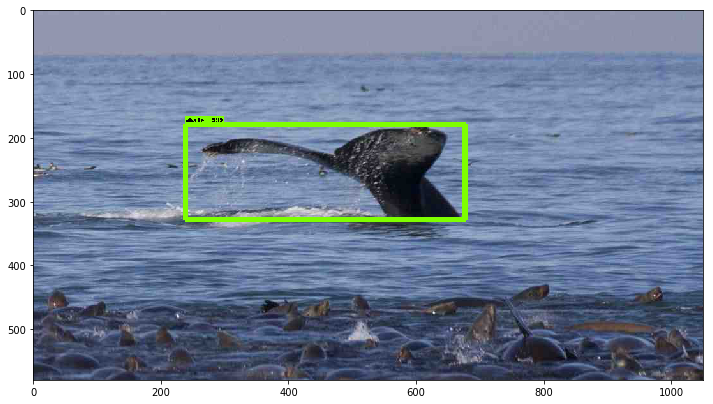

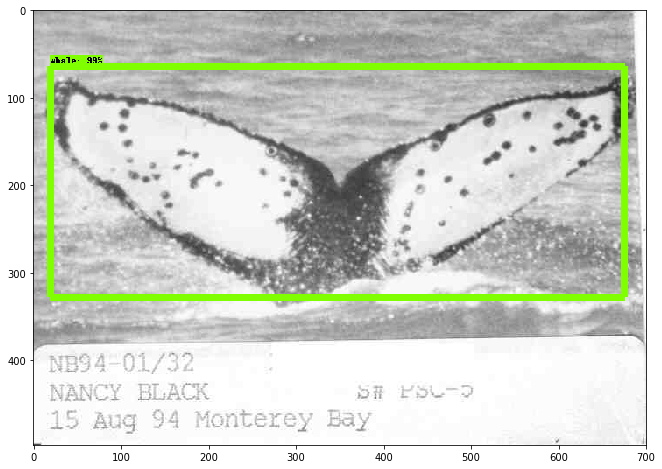

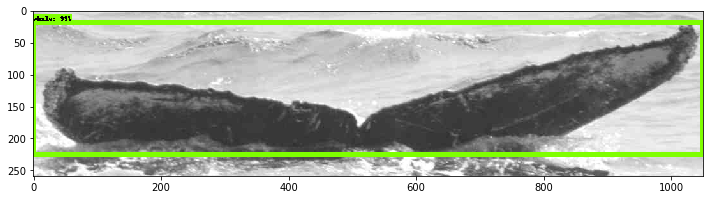

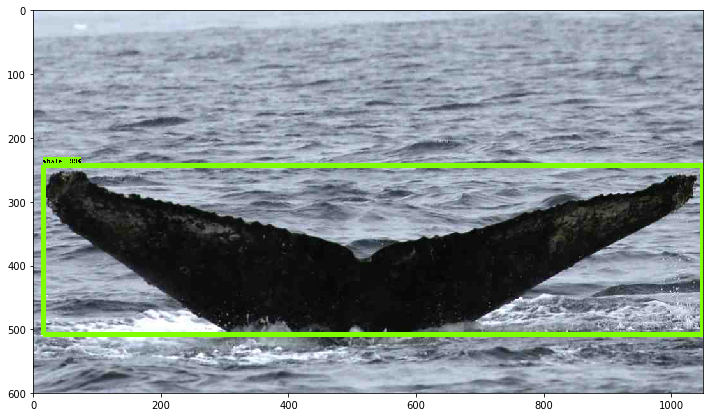

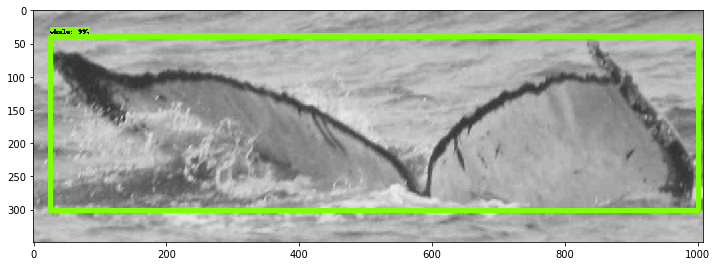

In [6]:
with detection_graph.as_default():
    with tf.Session() as sess:
        show_cropped_images(sess)